In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import random

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
import torch.nn.functional as F


from torch.utils.tensorboard import SummaryWriter

In [4]:
# specify GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# reproducibility
RANDOM_STATE = 0
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)



## Data Loading

In [6]:
DIR = os.getcwd()
if DIR.endswith("code"):
    DIR = DIR[:-5]
SAVED_IN = os.path.abspath(DIR + "/models" + "/NN_tuned_complex_fe_concat")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)
print(f"saved in: {SAVED_IN}")

from utils.plot_util import plot_one_gt_train_test, plot_gt_pre_overlap, plot_3_losses
from utils.data_util import (
    dotdict,
    extract_pos_s21_offset,
    load_pos_s21,
    save_pre,
    load_pre,
    PreprocessedDataset,
    get_dataloader,
)
from utils.nn_util import train_NN, count_parameters
from utils.complex_util import dict_act_complex, complex_normalize, NN_complex_fe_concat

saved in: c:\Users\xinch\Desktop\RBI\models\CNN_complex_fe


## Data Extraction

In [9]:
# load data
folder = os.path.join(DIR, "data")
data_file_name = os.path.join(folder, "data_offset_complex.pkl")
pos, s21, pos_TEST, s21_TEST = load_pos_s21(data_file_name, 5)

X = s21
Y = pos

X_TEST = s21_TEST
y_TEST = pos_TEST


## Data Preprocessing

### Train test split wit indicies

In [10]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, Y, indices, test_size=0.2, random_state=RANDOM_STATE
)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(411257, 121)
(411257,)
(102815, 121)
(102815,)


### Normalization

In [11]:
X_train_scaled, X_train_mean, X_train_std = complex_normalize(X_train)
X_test_scaled, X_test_mean, X_test_std = complex_normalize(X_test, X_train_mean, X_train_std)
X_TEST_scaled, X_TEST_mean, X_TEST_std = complex_normalize(X_TEST, X_train_mean, X_train_std)

X_scaled = np.zeros_like(X)
X_scaled[idx_train] = X_train_scaled
X_scaled[idx_test] = X_test_scaled

y_train = Y[idx_train].reshape(-1, 1)  # reshape to (N,1)
y_test = Y[idx_test].reshape(-1, 1)  # reshape to (N,1)
y_TEST = y_TEST.reshape(-1, 1)  # reshape to (N,1)

print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)
print(X_TEST_scaled.shape)
print(y_TEST.shape)


(411257, 121)
(411257, 1)
(102815, 121)
(102815, 1)
(20135, 121)
(20135, 1)


# NN_Fe

## 64-32

### Init

In [13]:
# configuration
_config = {
    "n_features": 121,
    "list_hidden": [64, 32],
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout":False, 
    "use_bn":False, 
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_complex_fe_concat(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act_complex[config.activation],
    device=device,
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_64-32.pth
NN_complex_fe_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=64, bias=True)
      (fc_i): Linear(in_features=121, out_features=64, bias=True)
    )
    (1): ComplexSigmoid()
    (2): ComplexLinear(
      (fc_r): Linear(in_features=64, out_features=32, bias=True)
      (fc_i): Linear(in_features=64, out_features=32, bias=True)
    )
    (3): ComplexSigmoid()
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)
number of learning parameters: 19962


In [14]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [15]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [16]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [17]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 970.34, test loss : 859.44, TEST loss : 854.14, lr: 0.0010
epoch : 10, train loss : 2.40, test loss : 2.32, TEST loss : 3.84, lr: 0.0010
epoch : 20, train loss : 1.46, test loss : 1.34, TEST loss : 2.23, lr: 0.0010
epoch : 30, train loss : 1.17, test loss : 1.16, TEST loss : 1.66, lr: 0.0010
epoch : 40, train loss : 1.05, test loss : 1.02, TEST loss : 1.48, lr: 0.0010
epoch : 50, train loss : 0.95, test loss : 0.88, TEST loss : 1.27, lr: 0.0010
Early stopping triggered
The minimal test loss is 0.84 from epoch 38


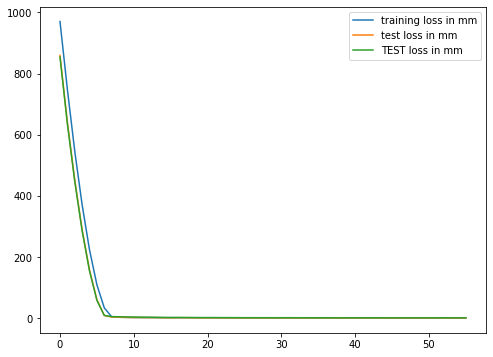

In [18]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [19]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_complex_fe_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=64, bias=True)
      (fc_i): Linear(in_features=121, out_features=64, bias=True)
    )
    (1): ComplexSigmoid()
    (2): ComplexLinear(
      (fc_r): Linear(in_features=64, out_features=32, bias=True)
      (fc_i): Linear(in_features=64, out_features=32, bias=True)
    )
    (3): ComplexSigmoid()
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [20]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.from_numpy(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.from_numpy(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 0.83 mm
test RMSE: 0.84 mm
TEST RMSE: 1.36 mm


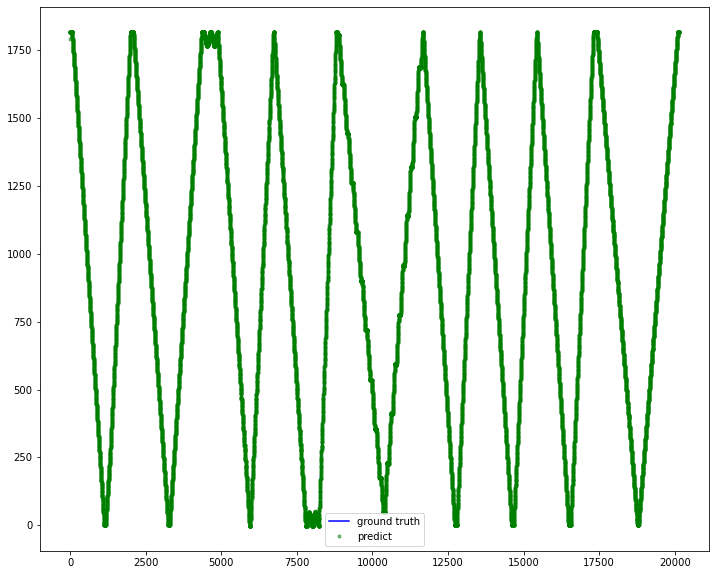

In [21]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


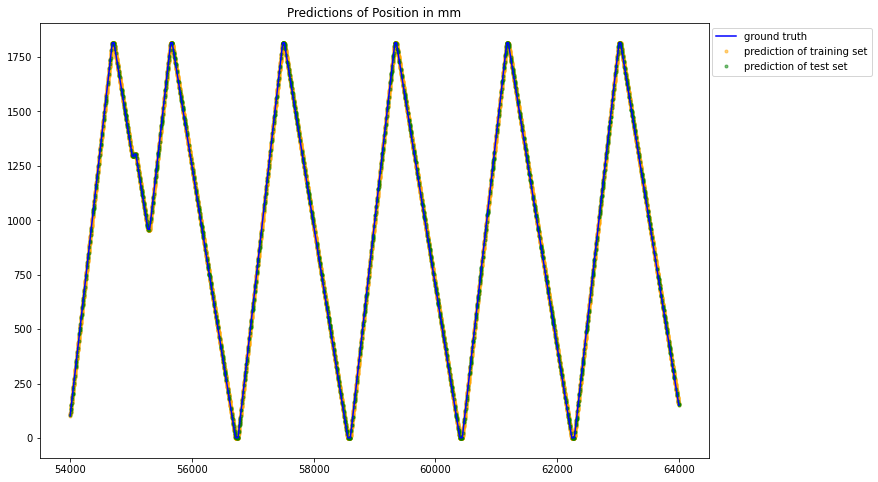

In [22]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 32-16

### Init

In [23]:
# configuration
_config = {
    "n_features": 121,
    "list_hidden": [32, 16],
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout":False, 
    "use_bn":False, 
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_complex_fe_concat(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act_complex[config.activation],
    device=device,
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16.pth
NN_complex_fe_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexSigmoid()
    (2): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=16, bias=True)
      (fc_i): Linear(in_features=32, out_features=16, bias=True)
    )
    (3): ComplexSigmoid()
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)
number of learning parameters: 9018


In [24]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [25]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [26]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [27]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1014.09, test loss : 950.70, TEST loss : 945.61, lr: 0.0010
epoch : 10, train loss : 13.98, test loss : 5.51, TEST loss : 6.12, lr: 0.0010
epoch : 20, train loss : 2.43, test loss : 2.56, TEST loss : 3.29, lr: 0.0010
epoch : 30, train loss : 1.89, test loss : 1.83, TEST loss : 2.35, lr: 0.0010
epoch : 40, train loss : 1.63, test loss : 1.56, TEST loss : 2.05, lr: 0.0010
epoch : 50, train loss : 1.48, test loss : 1.63, TEST loss : 2.15, lr: 0.0010
epoch : 60, train loss : 1.37, test loss : 1.47, TEST loss : 1.88, lr: 0.0010
epoch : 70, train loss : 1.30, test loss : 1.50, TEST loss : 1.93, lr: 0.0010
epoch : 80, train loss : 1.23, test loss : 1.21, TEST loss : 1.72, lr: 0.0010
epoch : 90, train loss : 1.18, test loss : 1.10, TEST loss : 1.66, lr: 0.0010
epoch : 100, train loss : 1.14, test loss : 1.08, TEST loss : 1.62, lr: 0.0010
epoch : 110, train loss : 1.09, test loss : 1.13, TEST loss : 1.63, lr: 0.0010
epoch : 120, train loss : 1.05, test loss : 1.04, TEST 

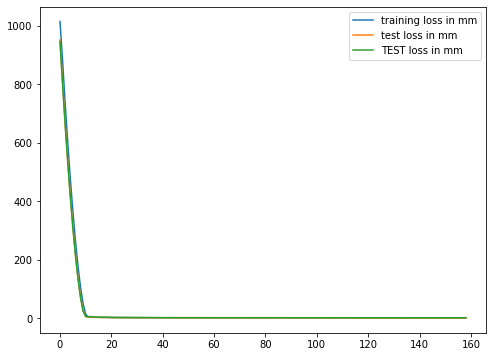

In [28]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [29]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_complex_fe_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexSigmoid()
    (2): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=16, bias=True)
      (fc_i): Linear(in_features=32, out_features=16, bias=True)
    )
    (3): ComplexSigmoid()
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [30]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.from_numpy(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.from_numpy(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 0.87 mm
test RMSE: 0.89 mm
TEST RMSE: 1.58 mm


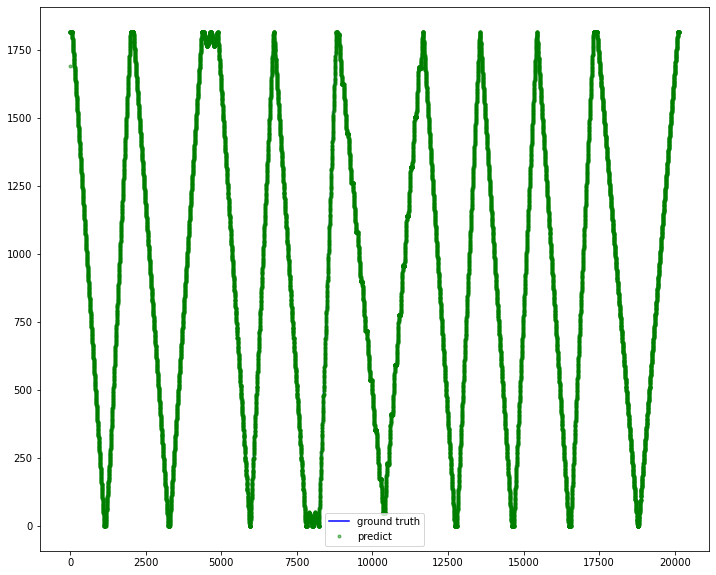

In [31]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


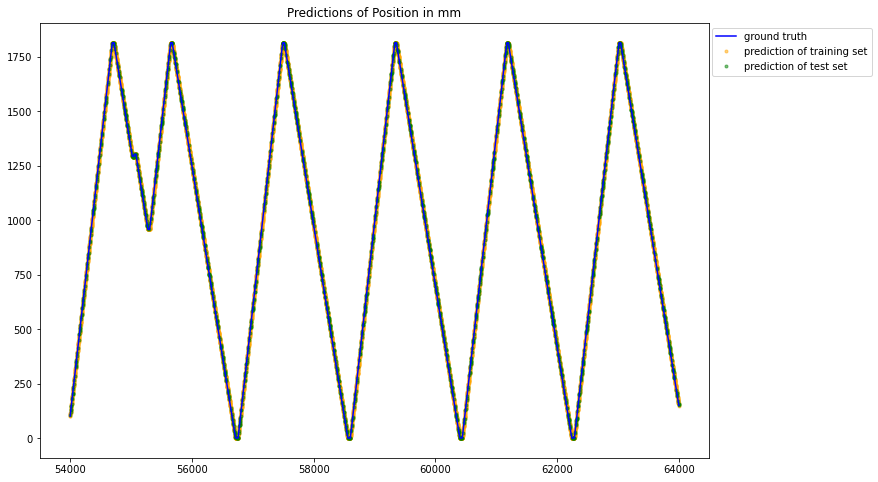

In [32]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 32-8

### Init

In [13]:
# configuration
_config = {
    "n_features": 121,
    "list_hidden": [32, 8],
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout":False, 
    "use_bn":False, 
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_complex_fe_concat(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act_complex[config.activation],
    device=device,
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-8.pth
NN_complex_fe_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexSigmoid()
    (2): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=8, bias=True)
      (fc_i): Linear(in_features=32, out_features=8, bias=True)
    )
    (3): ComplexSigmoid()
  )
  (out): Linear(in_features=16, out_features=1, bias=True)
)
number of learning parameters: 8474


In [14]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [15]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [16]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [17]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1045.46, test loss : 1014.36, TEST loss : 1009.41, lr: 0.0010
epoch : 10, train loss : 444.02, test loss : 418.88, TEST loss : 414.80, lr: 0.0010
epoch : 20, train loss : 55.45, test loss : 43.08, TEST loss : 41.53, lr: 0.0010
epoch : 30, train loss : 3.75, test loss : 3.32, TEST loss : 4.44, lr: 0.0010
epoch : 40, train loss : 2.88, test loss : 2.50, TEST loss : 3.47, lr: 0.0010
epoch : 50, train loss : 2.43, test loss : 2.39, TEST loss : 3.16, lr: 0.0010
epoch : 60, train loss : 2.21, test loss : 2.29, TEST loss : 3.13, lr: 0.0010
epoch : 70, train loss : 2.05, test loss : 1.88, TEST loss : 2.81, lr: 0.0010
epoch : 80, train loss : 1.92, test loss : 2.30, TEST loss : 3.15, lr: 0.0010
epoch : 90, train loss : 1.80, test loss : 1.70, TEST loss : 2.57, lr: 0.0010
epoch : 100, train loss : 1.73, test loss : 1.56, TEST loss : 2.53, lr: 0.0010
epoch : 110, train loss : 1.64, test loss : 1.54, TEST loss : 2.53, lr: 0.0010
epoch : 120, train loss : 1.58, test loss : 1

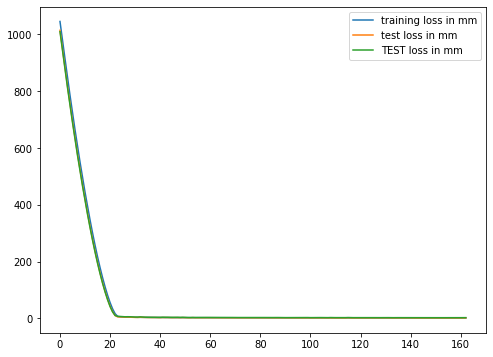

In [18]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [19]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_complex_fe_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexSigmoid()
    (2): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=8, bias=True)
      (fc_i): Linear(in_features=32, out_features=8, bias=True)
    )
    (3): ComplexSigmoid()
  )
  (out): Linear(in_features=16, out_features=1, bias=True)
)

In [20]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.from_numpy(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.from_numpy(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 1.27 mm
test RMSE: 1.30 mm
TEST RMSE: 2.33 mm


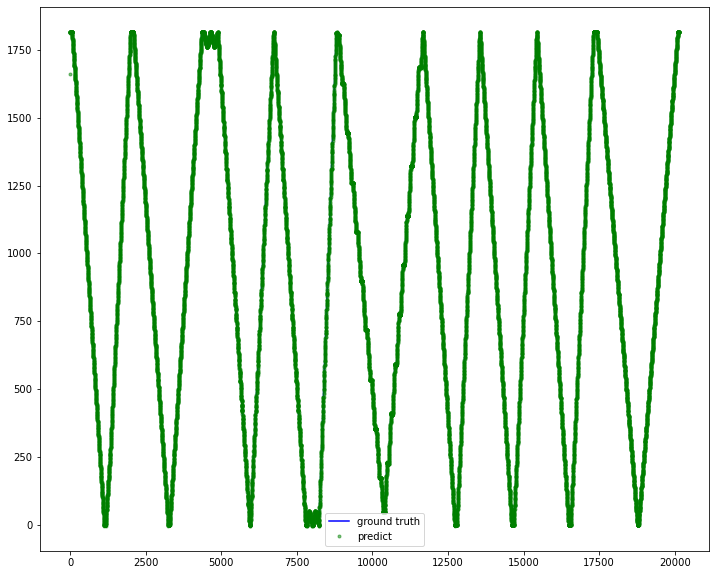

In [21]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


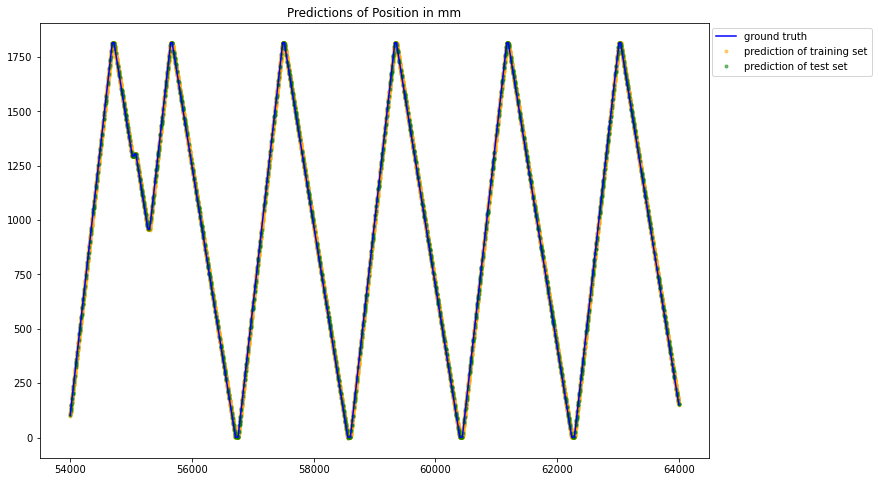

In [22]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)
